## Merging Data

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
# pip install pyBigWig
import pyBigWig

/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_20021/558774253.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [12]:
#merge data together 
cv_df = pd.read_csv("causal_variance_snps.csv")
hdf = pd.read_csv("heritability_scores.csv")

df = pd.merge(cv_df, hdf, how="inner", left_on="GeneID", right_on="TargetID")[['GeneID', 'NumCausalSNPs', 'Heritability_Score', 'Chromosome_y', 'CausalVariance']]
df.columns = ['GeneID', 'NumCausalSNPs', 'Heritability', 'Chr', 'CV']
df.head()

,GeneID,NumCausalSNPs,Heritability,Chr,CV
0,ENSG00000177757,0.0,0.380509,1,0.0
1,ENSG00000225880,0.0,0.339431,1,0.0
2,ENSG00000228794,0.0,0.000000,1,0.0
3,ENSG00000188976,0.0,0.062799,1,0.0
4,ENSG00000187961,0.0,0.260974,1,0.0


In [15]:
# group into 4 categories

conditions = [
    (df['Heritability'] >= 0.4) & (df['NumCausalSNPs'] < 3), 
    (df['Heritability'] >= 0.4) & (df['NumCausalSNPs'] >= 3), 
    (df['Heritability'] < 0.4) & (df['NumCausalSNPs'] < 3),   
    (df['Heritability'] < 0.4) & (df['NumCausalSNPs'] >= 3)   
]
labels = [
    'Large Heritablity, Few causal SNPs',
    'Large Heritablity, Many causal SNPs',
    'Small Heritablity, Few causal SNPs',
    'Small Heritablity, Many causal SNPs'
]
df['Category'] = np.select(conditions, labels, default='Uncategorized')
grouped_df = df.groupby('Category').size().reset_index(name='Count')
grouped_df

,Category,Count
0,"Large Heritablity, Few causal SNPs",612
1,"Large Heritablity, Many causal SNPs",17
2,"Small Heritablity, Few causal SNPs",12389
3,"Small Heritablity, Many causal SNPs",257


/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_17159/4089699029.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby('HeritabilityBin')['NumCausalSNPs'].mean().reset_index()


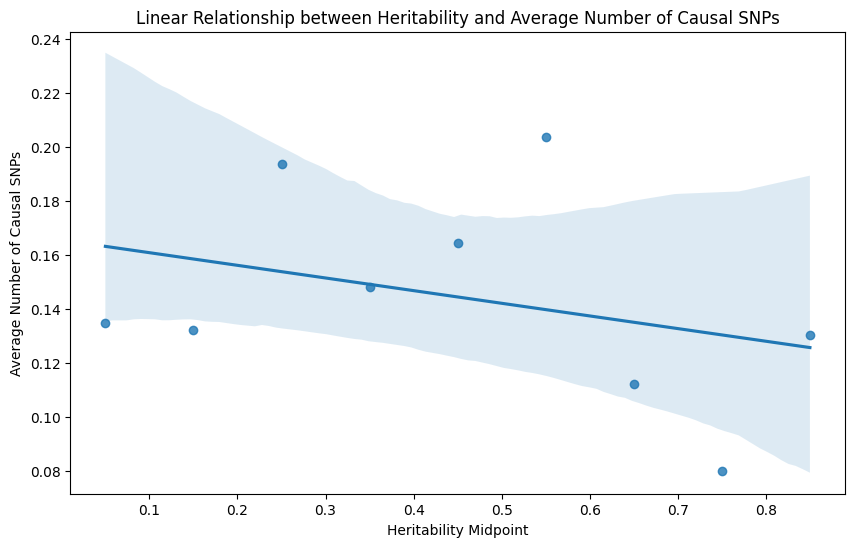

In [17]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
labels = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1']
df['HeritabilityBin'] = pd.cut(df['Heritability'], bins=bins, labels=labels, include_lowest=True)
grouped = df.groupby('HeritabilityBin')['NumCausalSNPs'].mean().reset_index()
grouped['HeritabilityMidpoint'] = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95]
# Plot 
plt.figure(figsize=(10, 6))
sns.regplot(x='HeritabilityMidpoint', y='NumCausalSNPs', data=grouped)
plt.xlabel('Heritability Midpoint')
plt.ylabel('Average Number of Causal SNPs')
plt.title('Linear Relationship between Heritability and Average Number of Causal SNPs')
plt.show()


# Causal Variance EDA

In [22]:
gene_annotation = pd.read_csv("gene_annotation.txt", sep="\t")
ldf = pd.merge(df, gene_annotation, how="inner", left_on="GeneID", right_on="SYM")
# Low number of causal snps combined with high causal variance 
gdf = df.groupby("Chr")[['CV', 'NumCausalSNPs']].mean().reset_index()

#boxplot

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Chr', y='NumCausalSNPs', data=df)
plt.title('Boxplot of Number of Causal SNPs per Chromosome')
plt.tight_layout()
plt.show()

#distributions
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['CV'], kde=True)
plt.title('Distribution of Causal Variance (CV)')
plt.subplot(1, 2, 2)
sns.histplot(df['NumCausalSNPs'], kde=True)
plt.title('Distribution of Number of Causal SNPs')
plt.tight_layout()
plt.show()

## GERP Scores

They are associated by position so merge the original gene ids with coordinates and ranges

In [26]:
bw = pyBigWig.open("All_hg19_RS.bw")
gene_annotation = pd.read_csv("gene_annotation.txt", sep="\t")
df = pd.merge(df, gene_annotation, how="inner", left_on="GeneID", right_on="SYM")
df['CHR'] = df['CHR'].astype(str)

In [33]:
bw = pyBigWig.open("All_hg19_RS.bw")
def get_gerp_score(start, stop, chromo):
    try:
        chromo = "chr" + chromo 
        scores = bw.values(chromo, int(start), int(stop))
        scores = [score for score in scores if score is not None]
        return sum(scores) / len(scores) if scores else None
    except Exception as e:
        print(f"Error processing row: start={start}, stop={stop}, chromo={chromo}, Error: {e}")
        return None

df['GERP Score'] = df.apply(lambda row: get_gerp_score(row['START'], row['STOP'], row['CHR']), axis=1)
bw.close()


Error processing row: start=197960199, stop=198043720, chromo=chr3, Error: Invalid interval bounds!
Error processing row: start=198152365, stop=198199015, chromo=chr3, Error: Invalid interval bounds!
Error processing row: start=181040224, stop=181061523, chromo=chr5, Error: Invalid interval bounds!
Error processing row: start=81189592, stop=81222999, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=81228276, stop=81239091, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=81239238, stop=81241281, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=81244999, stop=81295547, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=81509970, stop=81523847, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=81528395, stop=81537130, chromo=chr17, Error: Invalid interval bounds!
Error processing row: start=63034216, stop=63037028, chromo=chr20, Error: Invalid interval bounds!
Error p

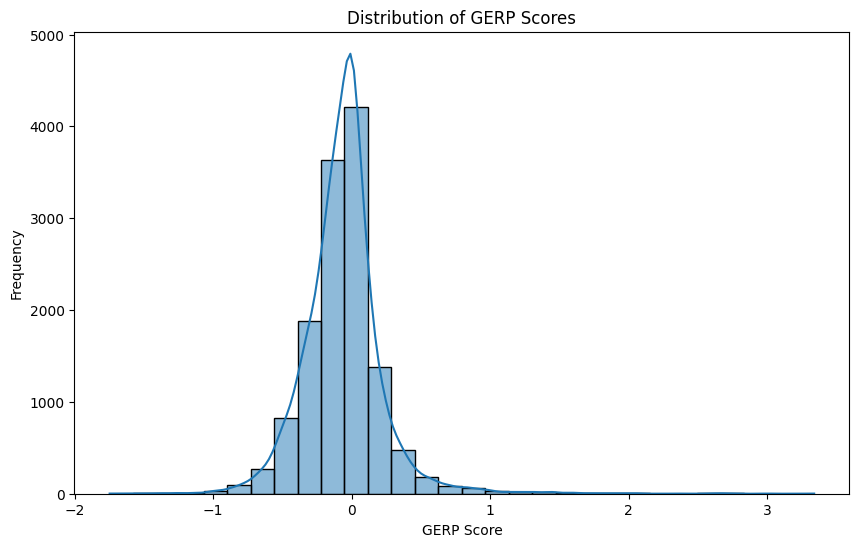

/Users/gurmandhaliwal/Library/CloudStorage/Dropbox/180B/myenv/lib/python3.9/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


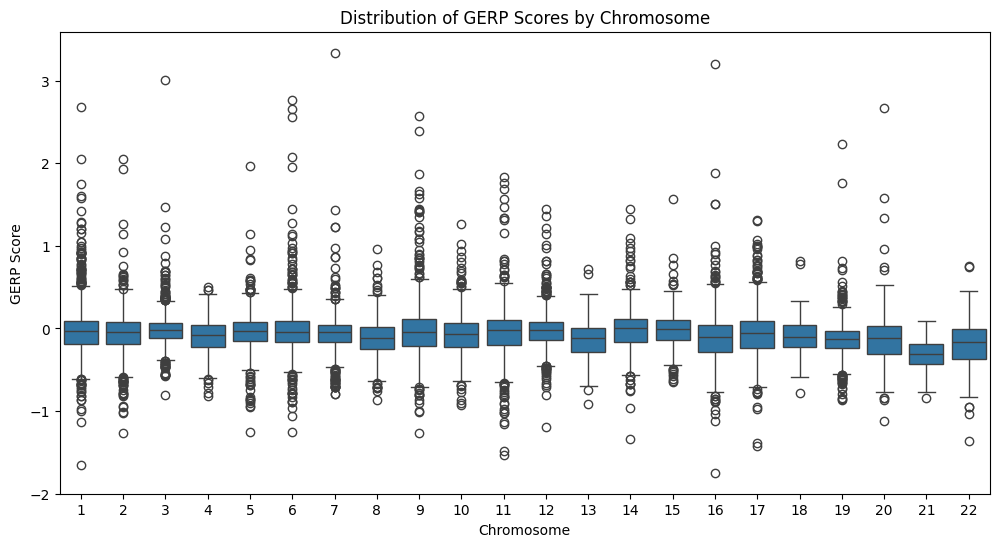

/Users/gurmandhaliwal/Library/CloudStorage/Dropbox/180B/myenv/lib/python3.9/site-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


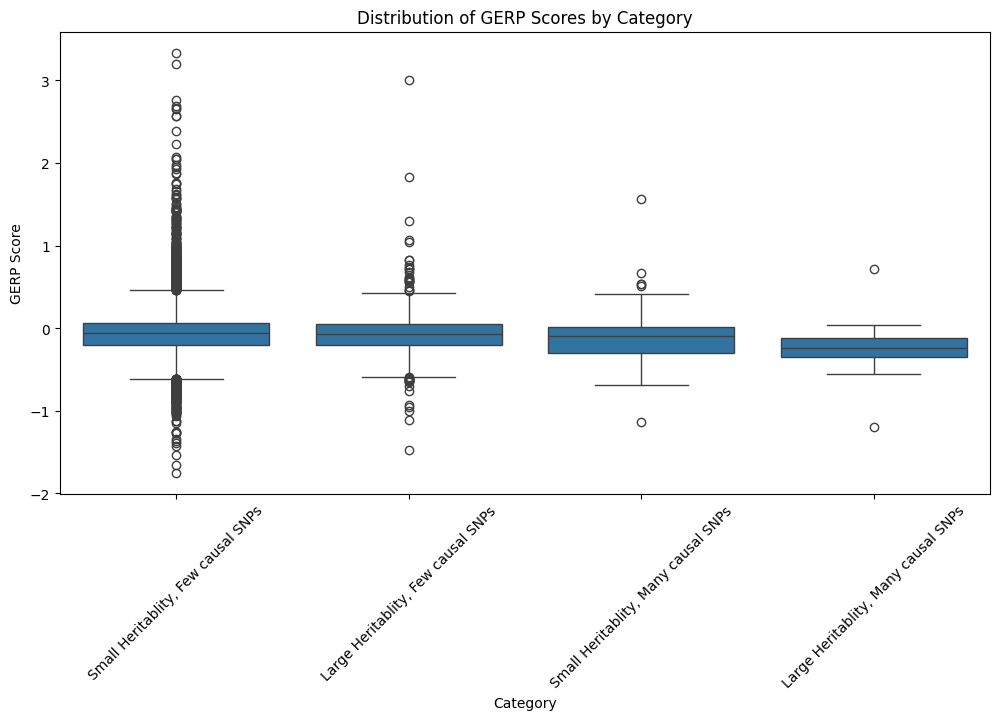

In [41]:
# dist 
plt.figure(figsize=(10, 6))
sns.histplot(df['GERP Score'], bins=30, kde=True)
plt.title('Distribution of GERP Scores')
plt.xlabel('GERP Score')
plt.ylabel('Frequency')
plt.show()

# by chr
plt.figure(figsize=(12, 6))
sns.boxplot(x='Chr', y='GERP Score', data=df)
plt.title('Distribution of GERP Scores by Chromosome')
plt.xlabel('Chromosome')
plt.ylabel('GERP Score')
plt.show()

# by cat 
plt.figure(figsize=(12, 6))
sns.boxplot(x='Category', y='GERP Score', data=df)
plt.title('Distribution of GERP Scores by Category')
plt.xticks(rotation=45)  
plt.xlabel('Category')
plt.ylabel('GERP Score')
plt.show()

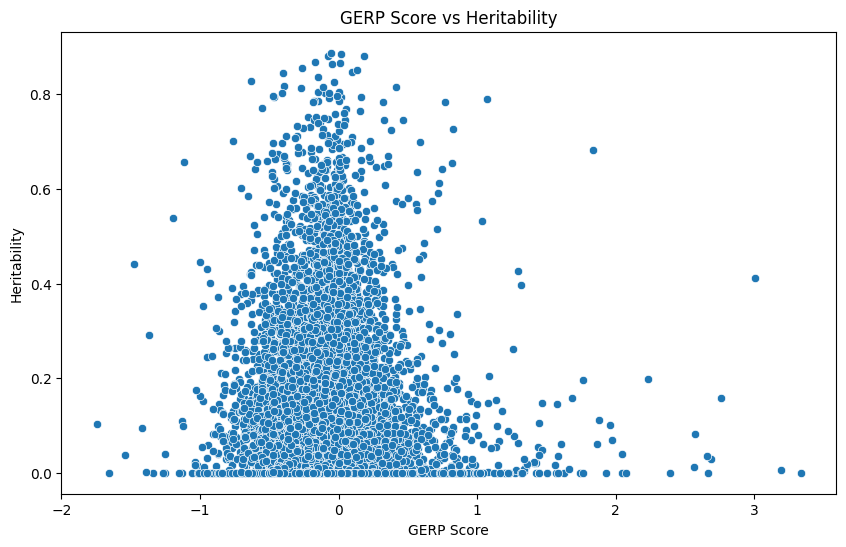

In [37]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GERP Score', y='Heritability', data=df)
plt.title('GERP Score vs Heritability')
plt.show()

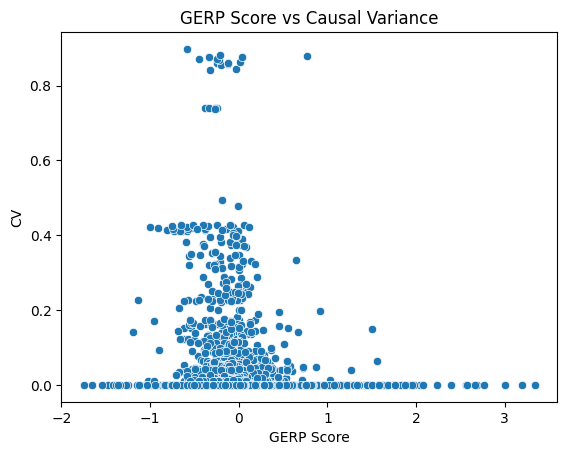

In [40]:
sns.scatterplot(x='GERP Score', y='CV', data=df)
plt.title('GERP Score vs Causal Variance')
plt.show()

In [46]:
df.groupby("Category")[['GERP Score']].mean()

,GERP Score
Category,
"Large Heritablity, Few causal SNPs",-0.063798
"Large Heritablity, Many causal SNPs",-0.251407
"Small Heritablity, Few causal SNPs",-0.060510
"Small Heritablity, Many causal SNPs",-0.117523


## TWAS

In [6]:
# http://ftp.ebi.ac.uk/pub/databases/gwas/summary_statistics/GCST007001-GCST008000/GCST007236/
# trait: breast carcinoma

sum_stats = pd.read_csv('bc.h.tsv', sep='\t')
sum_stats['Z'] = sum_stats['beta'] / sum_stats['standard_error']
sum_stats = sum_stats[['variant_id', 'effect_allele', 'other_allele', 'Z']]
sum_stats.columns = ['SNP', 'A1', 'A2', 'Z']
sum_stats.head()

/var/folders/dg/nlwnz_jj7rsblr2tzwj962b40000gn/T/ipykernel_20021/688481547.py:1: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  sum_stats = pd.read_csv('bc.h.tsv', sep='\t')


,SNP,A1,A2,Z
0,rs191890754,G,C,0.767229
1,rs184286948,C,G,1.094919
2,rs148331237,A,C,1.304792
3,rs183898652,T,C,1.863500
4,rs183186584,T,G,1.140088


In [7]:
sum_stats.to_csv('BreastCarcinoma_GWAS.txt', sep='\t', index=False)

This is the command to run in terminal. Make sure to download appropriate weights and software from the TWAS tutorial: 


Rscript FUSION.assoc_test.R \
--sumstats BreastCarcinoma_GWAS.txt \
--weights ./BRCA/TCGA-BRCA.TUMOR.pos \
--weights_dir ./BRCA/ \
--ref_ld_chr ./LDREF/1000G.EUR. \
--chr 22 \
--out BreastCarcinoma.22.dat


In [10]:
from statsmodels.stats.multitest import multipletests
twas_results = pd.read_csv("BreastCarcinoma.22.dat", sep='\t') 
twas_results

,PANEL,FILE,ID,CHR,P0,P1,HSQ,BEST.GWAS.ID,BEST.GWAS.Z,EQTL.ID,EQTL.R2,EQTL.Z,EQTL.GWAS.Z,NSNP,NWGT,MODEL,MODELCV.R2,MODELCV.PV,TWAS.Z,TWAS.P
0,TCGA-BRCA.TUMOR,./BRCA//TCGA-BRCA.TUMOR/TCGA-BRCA.TUMOR.psiTPT...,psiTPTE22,22,17082801,17179521,0.04021,rs5748593,-2.188,rs9604967,0.027659,-4.77,-1.22727,31,31,blup,0.0340,1.200000e-07,0.60320,5.46e-01
1,TCGA-BRCA.TUMOR,./BRCA//TCGA-BRCA.TUMOR/TCGA-BRCA.TUMOR.CECR7_...,CECR7,22,17517460,17539682,0.21709,rs17806634,-2.153,rs5748845,0.125467,10.00,-0.18149,60,20,enet,0.2300,1.200000e-46,-0.00254,9.98e-01
2,TCGA-BRCA.TUMOR,./BRCA//TCGA-BRCA.TUMOR/TCGA-BRCA.TUMOR.IL17RA...,IL17RA,22,17565849,17591387,0.10990,rs9606615,1.289,rs2895332,0.056646,-7.70,0.23839,76,12,enet,0.1000,1.400000e-20,-0.12921,8.97e-01
3,TCGA-BRCA.TUMOR,./BRCA//TCGA-BRCA.TUMOR/TCGA-BRCA.TUMOR.CECR1_...,CECR1,22,17660192,17702738,0.05276,rs16982255,-1.983,rs17807317,0.018238,6.09,-1.02263,79,11,enet,0.0410,6.000000e-09,-1.14904,2.51e-01
4,TCGA-BRCA.TUMOR,./BRCA//TCGA-BRCA.TUMOR/TCGA-BRCA.TUMOR.BCL2L1...,BCL2L13,22,18111682,18211987,0.02176,rs5992751,-2.495,rs17207051,0.017009,-4.31,-1.57790,98,1,top1,0.0170,1.500000e-04,1.57790,1.15e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,TCGA-BRCA.TUMOR,./BRCA//TCGA-BRCA.TUMOR/TCGA-BRCA.TUMOR.CPT1B_...,CPT1B,22,51007291,51017096,0.05494,rs5770953,-1.467,rs140521,0.003163,-3.75,0.02806,67,11,enet,0.0180,8.700000e-05,0.74149,4.58e-01
137,TCGA-BRCA.TUMOR,./BRCA//TCGA-BRCA.TUMOR/TCGA-BRCA.TUMOR.CHKB_1...,CHKB,22,51017378,51021428,0.01668,rs5770953,-1.467,rs131748,0.000733,-3.74,0.28698,64,5,enet,0.0067,1.300000e-02,-0.64943,5.16e-01
138,TCGA-BRCA.TUMOR,./BRCA//TCGA-BRCA.TUMOR/TCGA-BRCA.TUMOR.LOC100...,LOC100144603,22,51021455,51022353,0.14485,rs5770953,-1.467,rs131760,0.084962,8.32,0.13108,64,23,enet,0.1100,1.100000e-21,0.01103,9.91e-01
139,TCGA-BRCA.TUMOR,./BRCA//TCGA-BRCA.TUMOR/TCGA-BRCA.TUMOR.ARSA_4...,ARSA,22,51063450,51066607,0.34292,rs5770953,-1.467,rs6151429,0.296491,-15.32,-1.17824,54,1,top1,0.3000,1.500000e-61,1.17824,2.39e-01


In [17]:
def try_convert_to_float(x):
    try:
        return float(x)
    except ValueError:  
        return np.nan
    
float_cols = ['HSQ', 'BEST.GWAS.Z', 'EQTL.R2', 'EQTL.Z', 'EQTL.GWAS.Z', 'TWAS.Z', 'TWAS.P']
for col in float_cols:
    twas_results[col] = twas_results[col].apply(lambda x: try_convert_to_float(x))
twas_results['CHR'] = twas_results['CHR'].astype(str)

In [18]:
# correct for multiple testing
from statsmodels.stats.multitest import multipletests

pvals_corrected = multipletests(twas_results['TWAS.P'].dropna(), method='fdr_bh')[1]
twas_results.loc[twas_results['TWAS.P'].notnull(), 'TWAS.P.adj'] = pvals_corrected


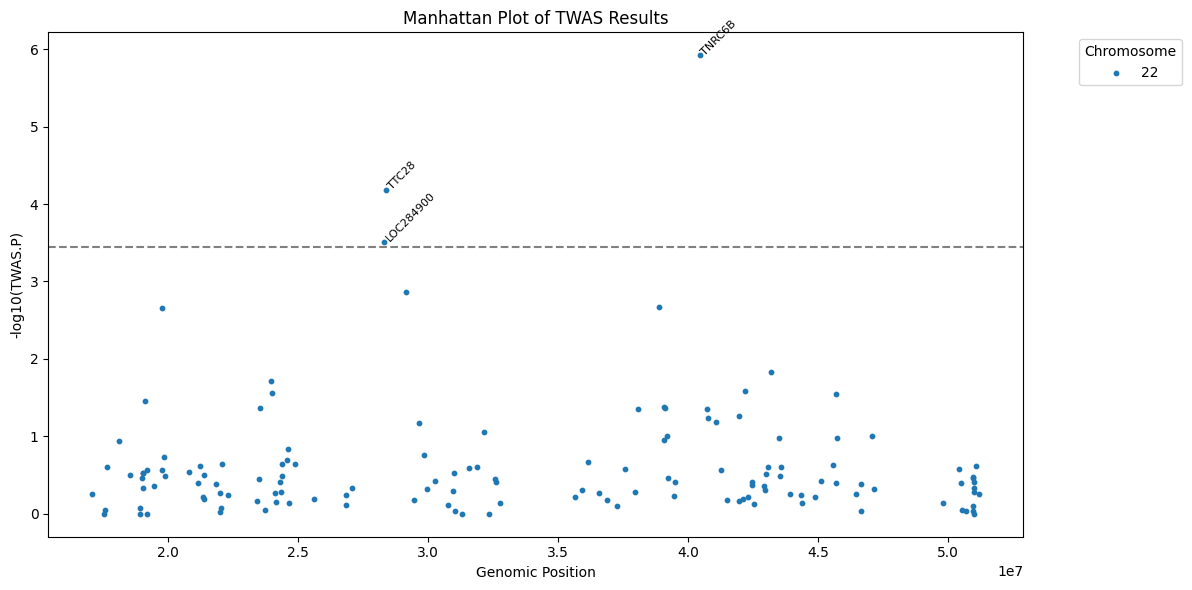

In [23]:
def plot_manhattan(df):
    df['-log10(TWAS.P)'] = -np.log10(df['TWAS.P'].replace(0, np.nan))
    df.sort_values(['CHR', 'P0'], inplace=True)
    df['CHR_num'] = df['CHR'].map(dict(zip(df['CHR'].unique(), range(1, len(df['CHR'].unique()) + 1))))
    num_chromosomes = len(df['CHR'].unique())
    colors = ['red', 'blue'] * (num_chromosomes // 2 + 1)  

    plt.figure(figsize=(12, 6))
    significance_threshold = -np.log10(0.05 / len(df))
    
    for chrom in df['CHR'].unique():
        chrom_df = df[df['CHR'] == chrom]
        plt.scatter(chrom_df['P0'], chrom_df['-log10(TWAS.P)'], label=chrom, s=10)
        
        significant_snps = chrom_df[chrom_df['-log10(TWAS.P)'] > significance_threshold]
        for _, row in significant_snps.iterrows():
            plt.text(row['P0'], row['-log10(TWAS.P)'], row['ID'], fontsize=8, rotation=45)

    plt.xlabel('Genomic Position')
    plt.ylabel('-log10(TWAS.P)')
    plt.title('Manhattan Plot of TWAS Results')
    plt.axhline(y=significance_threshold, color='grey', linestyle='--')  # Draw significance threshold line
    plt.legend(title='Chromosome', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)
    plt.tight_layout()
    plt.show()


plot_manhattan(twas_results)


In [22]:
twas_results['TWAS.P'] = twas_results['TWAS.P'].astype(float)
significant = twas_results[twas_results['TWAS.P'] < 0.05]
print(f"Number of significant associations before correction: {significant.shape[0]}")


Number of significant associations before correction: 17


This is a work in progress. 

That was just for one chromosome, we can run this analysis on all of them by running the following script: 

./run_fusion_all_chromosomes.sh
